In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
from CellType_PSY import *
import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

import requests
import SimpleITK as sitk
import pathlib

from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import alphashape
from alpha_shapes.boundary import Boundary, get_boundaries

from descartes import PolygonPatch
from alpha_shapes import Alpha_Shaper, plot_alpha_shape

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
def get_region_shape(section, reg, level="structure"):
    if level == "structure":
        sub_section = section[section["parcellation_structure"]==reg]
    elif level == "division":
        sub_section = section[section["parcellation_division"]==reg]
    points = sub_section[["x_reconstructed", "y_reconstructed"]].values
    print(points.shape)
    shaper = Alpha_Shaper(points)
    alpha_opt, alpha_shape = shaper.optimize()
    alpha_shape = shaper.get_shape(alpha=alpha_opt * 0.6)
    
    condition = points[:, 0] < 6
    subset_data = points[condition]
    center = subset_data.mean(axis=0)
    return alpha_shape, center
def add_region_bound(plt, alpha_shape, center, reg):
    for bound in get_boundaries(alpha_shape):
        data = bound._exterior
        plt.plot(data[:,0], data[:,1], color='black', linestyle='dashed', linewidth=1.5)
        holes = bound._holes
        for hole in holes:
            plt.plot(hole[:,0], hole[:,1], color='black', linestyle='dashed', linewidth=1.5)
        plt.text(x=center[0] - 0.5, y=center[1], s=reg)

In [3]:
ClusterAnn = pd.read_excel("../../data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM8_ESM.xlsx",
                          sheet_name = "cluster_annotation", index_col="cluster_id_label")

In [4]:
MERFISH = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/MERFISH.ISH_Annot.clean.csv", index_col=0)

In [7]:
MERFISH[MERFISH["parcellation_structure"]=="CA1"]["brain_section_label"].value_counts()

C57BL6J-638850.30    8911
C57BL6J-638850.31    8422
C57BL6J-638850.32    7776
C57BL6J-638850.33    4747
C57BL6J-638850.38    4441
C57BL6J-638850.36    4169
C57BL6J-638850.29    3961
C57BL6J-638850.40    3705
C57BL6J-638850.37    3401
C57BL6J-638850.35    1768
C57BL6J-638850.39    1766
C57BL6J-638850.42    1673
C57BL6J-638850.28    1508
C57BL6J-638850.43     154
Name: brain_section_label, dtype: int64

In [8]:
CA1_MERFISH = MERFISH[MERFISH["parcellation_structure"]=="CA1"]

In [9]:
CA1_MERFISH.shape

(56402, 38)

In [10]:
brain_section = 'C57BL6J-638850.30'
pred = (CA1_MERFISH['brain_section_label'] == brain_section)
section = CA1_MERFISH[pred]
print(len(section))

8911


In [13]:
section.columns.values

array(['brain_section_label', 'cluster_alias',
       'average_correlation_score', 'feature_matrix_label', 'donor_label',
       'donor_genotype', 'donor_sex', 'x_section', 'y_section',
       'z_section', 'neurotransmitter', 'class', 'subclass', 'supertype',
       'cluster', 'neurotransmitter_color', 'class_color',
       'subclass_color', 'supertype_color', 'cluster_color',
       'x_reconstructed', 'y_reconstructed', 'z_reconstructed',
       'parcellation_index', 'x_ccf', 'y_ccf', 'z_ccf',
       'parcellation_organ', 'parcellation_category',
       'parcellation_division', 'parcellation_structure',
       'parcellation_substructure', 'parcellation_organ_color',
       'parcellation_category_color', 'parcellation_division_color',
       'parcellation_structure_color', 'parcellation_substructure_color',
       'ISH_STR'], dtype=object)

In [12]:
section.head(2)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color,ISH_STR
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344100920829,C57BL6J-638850.30,2762,0.698616,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.015226,7.98796,5.0,...,grey,HPF,CA1,CA1so,#FFFFFF,#BFDAE3,#7ED04B,#7ED04B,#7ED04B,Field CA1
1018093344102590128-1,C57BL6J-638850.30,2762,0.692166,C57BL6J-638850,C57BL6J-638850,wt/wt,M,8.145984,7.36671,5.0,...,grey,HPF,CA1,CA1slm,#FFFFFF,#BFDAE3,#7ED04B,#7ED04B,#7ED04B,Field CA1


In [31]:
section["subclass"].value_counts()/section["subclass"].shape[0]

016 CA1-ProS Glut               0.277971
319 Astro-TE NN                 0.221412
023 SUB-ProS Glut               0.096959
333 Endo NN                     0.082146
327 Oligo NN                    0.045674
053 Sst Gaba                    0.036247
052 Pvalb Gaba                  0.028504
326 OPC NN                      0.028055
014 LA-BLA-BMA-PA Glut          0.025923
033 NP SUB Glut                 0.024127
015 ENTmv-PA-COAp Glut          0.021546
334 Microglia NN                0.019526
046 Vip Gaba                    0.014589
331 Peri NN                     0.012793
048 RHP-COA Ndnf Gaba           0.010661
049 Lamp5 Gaba                  0.008304
330 VLMC NN                     0.007631
028 L6b/CT ENT Glut             0.005835
332 SMC NN                      0.005835
031 CT SUB Glut                 0.005723
047 Sncg Gaba                   0.004264
050 Lamp5 Lhx6 Gaba             0.003479
002 IT EP-CLA Glut              0.001796
013 COAp Grxcr2 Glut            0.001347
036 HPF CR Glut 

In [16]:
def plot_section( xx=None, yy=None, cc=None, val=None, pcmap=None, 
                 overlay=None, extent=None, bcmap=plt.cm.Greys_r, alpha=1.0,
                 fig_width = 6, fig_height = 6 ) :
    
    fig, ax = plt.subplots(dpi=480)
    fig.set_size_inches(fig_width, fig_height)

    if xx is not None and yy is not None and pcmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=pcmap)
    elif xx is not None and yy is not None and cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.',zorder=1)   
        
    if overlay is not None and extent is not None and bcmap is not None :
        plt.imshow(overlay, cmap=bcmap, extent=extent,alpha=alpha,zorder=2)
        
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

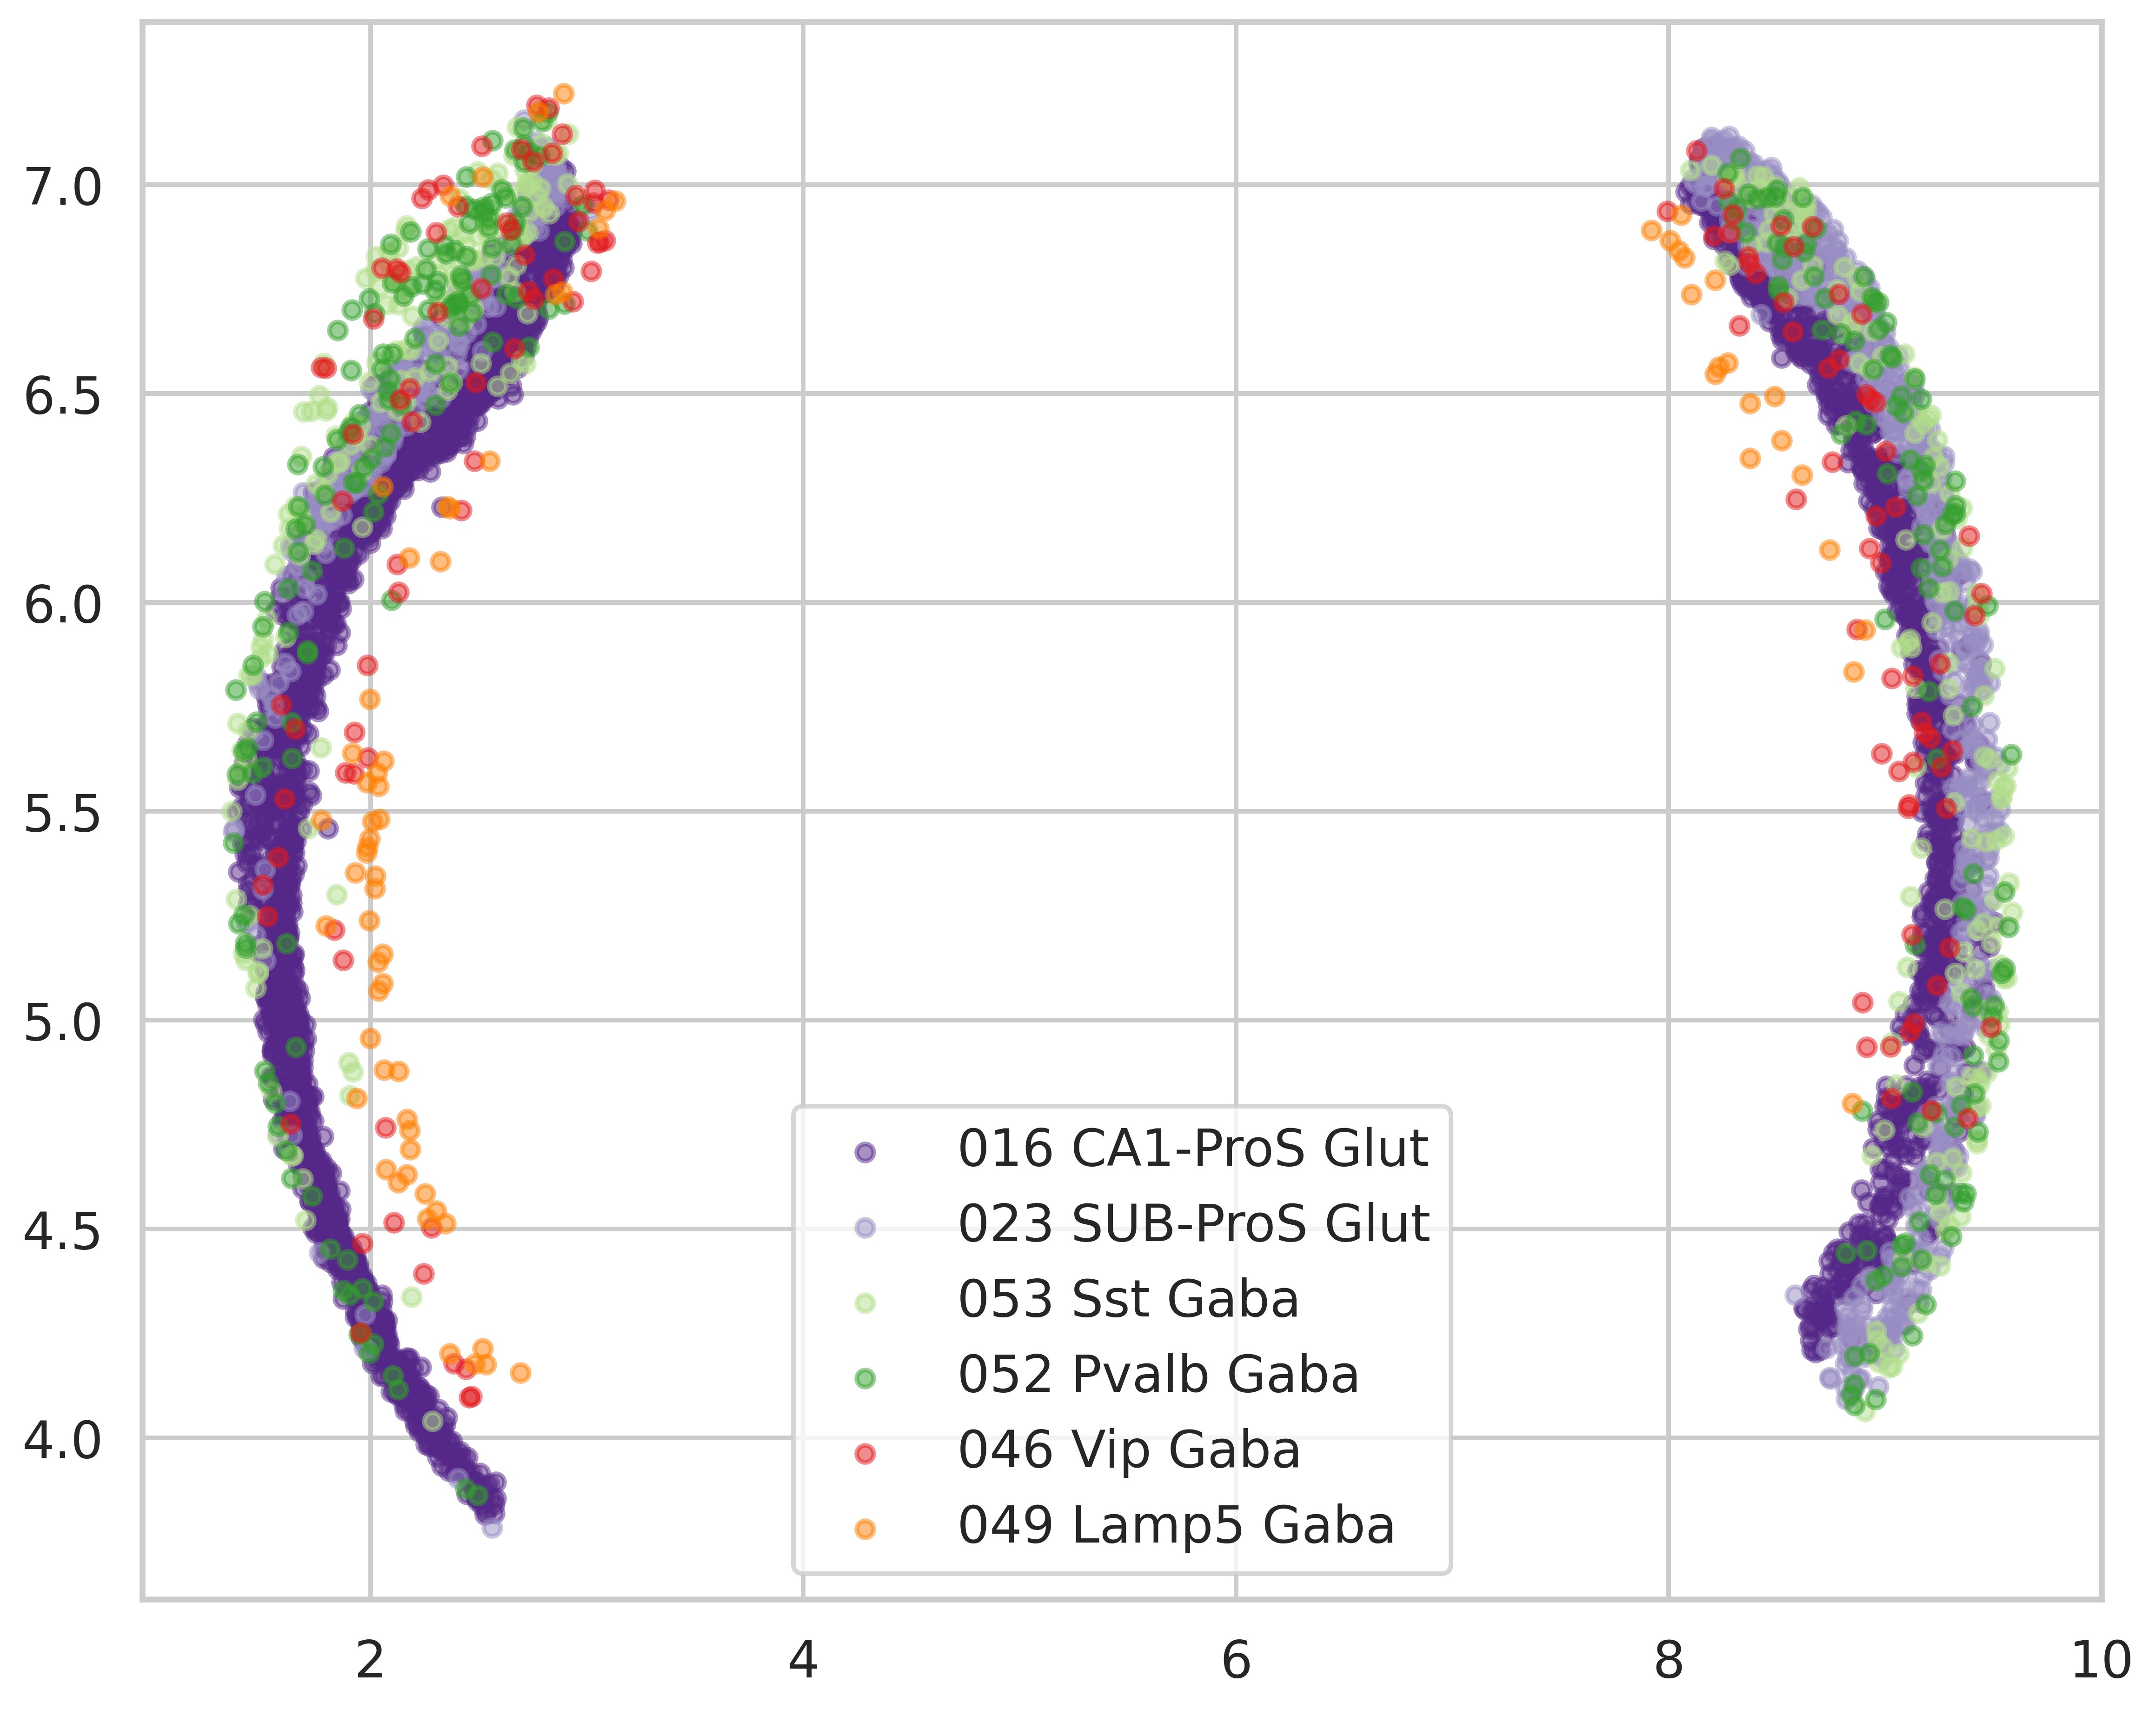

In [29]:
sns.set(style="whitegrid", context="talk")
plt.figure(dpi=480, figsize=(10, 8))
CTs = ["016 CA1-ProS Glut", "023 SUB-ProS Glut", 
                  "053 Sst Gaba", "052 Pvalb Gaba", 
                  "046 Vip Gaba", "049 Lamp5 Gaba"]
Colors = ["#542788", "#998ec3", "#b2df8a", "#33a02c",
         "#e31a1c", "#ff7f00"]
color_dict = dict(zip(CTs, Colors))
for _subclass in CTs:
    _setction = section[section["subclass"]==_subclass]
    plt.scatter(_setction["x_reconstructed"], _setction["y_reconstructed"], color=color_dict[_subclass], 
                label=_subclass, s=30, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
(section["subclass"].value_counts()/section["subclass"].shape[0])[CTs]

016 CA1-ProS Glut    0.277971
023 SUB-ProS Glut    0.096959
053 Sst Gaba         0.036247
052 Pvalb Gaba       0.028504
046 Vip Gaba         0.014589
049 Lamp5 Gaba       0.008304
Name: subclass, dtype: float64

In [37]:
for n in np.arange(28, 42):
    try:
        print(n)
        brain_section = 'C57BL6J-638850.{}'.format(n)
        pred = (CA1_MERFISH['brain_section_label'] == brain_section)
        section = CA1_MERFISH[pred]
        print((section["subclass"].value_counts()/section["subclass"].shape[0])[CTs])
    except:
        continue

28
016 CA1-ProS Glut    0.179708
023 SUB-ProS Glut    0.204244
053 Sst Gaba         0.042440
052 Pvalb Gaba       0.050398
046 Vip Gaba         0.016578
049 Lamp5 Gaba       0.002653
Name: subclass, dtype: float64
29
016 CA1-ProS Glut    0.224943
023 SUB-ProS Glut    0.133300
053 Sst Gaba         0.036859
052 Pvalb Gaba       0.030548
046 Vip Gaba         0.017420
049 Lamp5 Gaba       0.007321
Name: subclass, dtype: float64
30
016 CA1-ProS Glut    0.277971
023 SUB-ProS Glut    0.096959
053 Sst Gaba         0.036247
052 Pvalb Gaba       0.028504
046 Vip Gaba         0.014589
049 Lamp5 Gaba       0.008304
Name: subclass, dtype: float64
31
016 CA1-ProS Glut    0.400617
023 SUB-ProS Glut    0.039302
053 Sst Gaba         0.023510
052 Pvalb Gaba       0.021135
046 Vip Gaba         0.011755
049 Lamp5 Gaba       0.007718
Name: subclass, dtype: float64
32
016 CA1-ProS Glut    0.424769
023 SUB-ProS Glut    0.027392
053 Sst Gaba         0.020833
052 Pvalb Gaba       0.017361
046 Vip Gaba         